In [10]:
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

In [2]:
"""
The BLEU score is a metric for evaluating a generated sentence to a reference sentence. 
It is based on the n-gram precision between the generated sentence and the reference sentence.
The BLEU score ranges from 0 to 1, where 1 means the generated sentence is identical to the reference sentence.

The ROUGE score is a metric for evaluating a generated sentence to a reference sentence.
It is based on the overlap of n-grams between the generated sentence and the reference sentence.
The ROUGE score ranges from 0 to 1, where 1 means the generated sentence is identical to the reference sentence.
"""

def calculate_bleu_score(answers_target, answers_predicted):
  references = [[answer] for answer in answers_target]
  predictions = answers_predicted

  return corpus_bleu(references, predictions)

def calculate_rouge_score(answers_target, answers_predicted):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  total_rouge1, total_rouge2, total_rougeL = 0, 0, 0
  for gen, ref in zip(answers_predicted, answers_target):
    scores = scorer.score(gen, ref)
    total_rouge1 += scores['rouge1'].fmeasure
    total_rouge2 += scores['rouge2'].fmeasure
    total_rougeL += scores['rougeL'].fmeasure
  avg_rouge1 = total_rouge1 / len(answers_target)
  avg_rouge2 = total_rouge2 / len(answers_target)
  avg_rougeL = total_rougeL / len(answers_target)
  return avg_rouge1, avg_rouge2, avg_rougeL

In [15]:
def benchmark():
  answers_inline_context_df = pd.read_json('./benchmark_data/answers_inline_context.jsonl', lines=True)
  answers_vector_db_df = pd.read_json('./benchmark_data/answers_vector_db.jsonl', lines=True)
  answers_target_df = pd.read_json('./benchmark_data/answers_target.jsonl', lines=True)

  answers_inline_context = answers_inline_context_df['answer'].tolist()
  answers_vector_db = answers_vector_db_df['answer'].tolist()
  answers_target = answers_target_df['answer'].tolist()

  bleu_score_inline_context = calculate_bleu_score(answers_target, answers_inline_context)
  bleu_score_vector_db = calculate_bleu_score(answers_target, answers_vector_db)

  avg_rouge1_inline_context, avg_rouge2_inline_context, avg_rougeL_inline_context = calculate_rouge_score(answers_target, answers_inline_context)
  avg_rouge1_vector_db, avg_rouge2_vector_db, avg_rougeL_vector_db = calculate_rouge_score(answers_target, answers_vector_db)
  
  results_df = pd.DataFrame({
    'Model': ['Inline Context', 'Vector DB'],
    'BLEU Score': [bleu_score_inline_context, bleu_score_vector_db],
    'ROUGE-1': [avg_rouge1_inline_context, avg_rouge1_vector_db],
    'ROUGE-2': [avg_rouge2_inline_context, avg_rouge2_vector_db],
    'ROUGE-L': [avg_rougeL_inline_context, avg_rougeL_vector_db],
  })

  costs_df = pd.DataFrame({
    'Model': ['Inline Context', 'Vector DB'],
    'Avg Prompt Tokens': [
      answers_inline_context_df['prompt_tokens'].mean(),
      answers_vector_db_df['prompt_tokens'].mean()
    ],
    'Avg Input Cost': [
      answers_inline_context_df['prompt_tokens'].mean() * 0.000005,
      answers_vector_db_df['prompt_tokens'].mean() * 0.000005
    ],
    'Avg Completion Tokens': [
      answers_inline_context_df['completion_tokens'].mean(),
      answers_vector_db_df['completion_tokens'].mean()
    ],
    'Avg Output Cost': [
      answers_inline_context_df['completion_tokens'].mean() * 0.000015,
      answers_vector_db_df['completion_tokens'].mean() * 0.000015
    ],
    'Avg Total Tokens': [
      answers_inline_context_df['total_tokens'].mean(),
      answers_vector_db_df['total_tokens'].mean()
    ],
  })

  costs_df['Avg Total Cost'] = costs_df['Avg Input Cost'] + costs_df['Avg Output Cost']

  print(results_df.T)
  print()
  print(costs_df.T)

  return results_df, costs_df

In [16]:
results_df, costs_df = benchmark()

                         0          1
Model       Inline Context  Vector DB
BLEU Score        0.265685   0.227175
ROUGE-1            0.45494   0.425944
ROUGE-2           0.304204   0.274646
ROUGE-L           0.396724   0.334743

                                    0          1
Model                  Inline Context  Vector DB
Avg Prompt Tokens           20273.975  16883.675
Avg Input Cost                0.10137   0.084418
Avg Completion Tokens           146.0      218.1
Avg Output Cost               0.00219   0.003272
Avg Total Tokens            20419.975  17101.775
Avg Total Cost                0.10356    0.08769


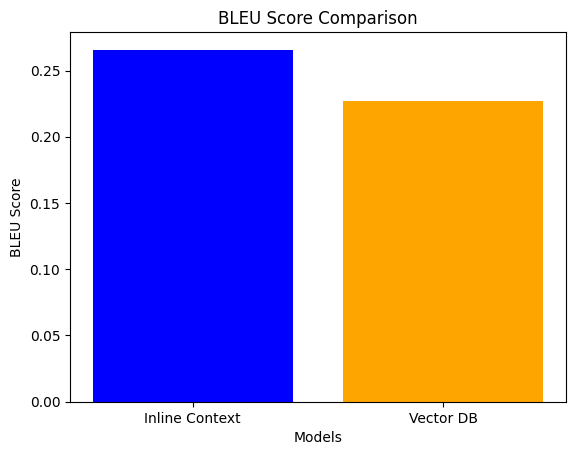

In [17]:
# Data
models = ['Inline Context', 'Vector DB']
bleu_scores = results_df['BLEU Score'].tolist()

# Plot
plt.bar(models, bleu_scores, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('BLEU Score')
plt.title('BLEU Score Comparison')
plt.show()

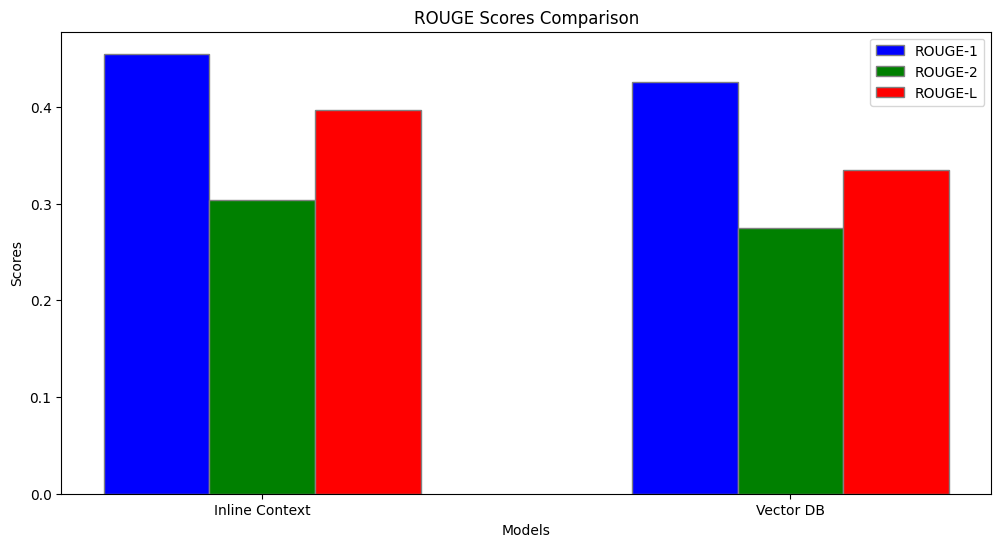

In [18]:
import numpy as np

# Data
rouge_1 = results_df['ROUGE-1'].tolist()
rouge_2 = results_df['ROUGE-2'].tolist()
rouge_l = results_df['ROUGE-L'].tolist()

# Bar Width
bar_width = 0.2

# Positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(r1, rouge_1, color='blue', width=bar_width, edgecolor='grey', label='ROUGE-1')
plt.bar(r2, rouge_2, color='green', width=bar_width, edgecolor='grey', label='ROUGE-2')
plt.bar(r3, rouge_l, color='red', width=bar_width, edgecolor='grey', label='ROUGE-L')

# Add labels
plt.xlabel('Models')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('ROUGE Scores Comparison')
plt.legend()
plt.show()

The BLEU score is a measure of the precision of retrieved answers, indicating how many words match with the reference answers.
ROUGE scores measure recall, indicating how well the retrieved answers cover the reference answers.

The evaluation metrics used to compare the performance of the ‘Inline Context’ and ‘Vector DB’ models are BLEU and ROUGE scores, which are typically used in translation tasks but can also indicate the quality of retrieved answers in terms of precision and recall. The ‘Inline Context’ model consistently outperformed the ‘Vector DB’ model across all metrics, suggesting it is better at retrieving accurate and relevant answers.